In [1]:
from llama_index import StorageContext, VectorStoreIndex, PromptTemplate, load_index_from_storage
from llama_index.tools import QueryEngineTool, ToolMetadata, FunctionTool
from llama_index.multi_modal_llms.generic_utils import load_image_urls
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.query_engine import PandasQueryEngine
from llama_index.readers import PDFReader
from llama_index.agent import ReActAgent
from llama_index.llms import OpenAI
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from io import BytesIO
from PIL import Image
import pandas as pd
import importlib
import requests
import os

# API key
load_dotenv()

True

# Engines for multiplication, script running, and note taking

In [2]:
# Multiplyer function
def multiply(a: int, b: int) -> int:
    """Multiply two integers and returns the result integer"""
    return a * b

sudoku_path = 'sudoku_solver.py'

# Script caller - Sudoku game in this case
def run_example_script(script_path):
    """Run a local example script"""
    try:
      with open(script_path, 'r') as file:
         python_code = file.read()
         exec(python_code)
    except FileNotFoundError:
      return(f"Error: The file '{script_path}' could not be found.")
      
    return 'File executed'

note_file = os.path.join('data', 'notes.txt')

# Note saver function
def save_note(note):
    if not os.path.exists(note_file):
        open(note_file, 'w')

    with open(note_file, 'a') as file:
        file.writelines([note + '\n'])

    return 'Note saved'

# Tools for the agent
multiply_engine = FunctionTool.from_defaults(
   fn=multiply,
   name='integer_multiplier',
   description='This tool can multiply two integers and return the resulting integer'
)
script_caller_engine = FunctionTool.from_defaults(
   fn=run_example_script,
   name='example_script_runner',
   description='This tool can run a local example script'
)
note_engine = FunctionTool.from_defaults(
    fn=save_note,
    name='note_saver',
    description='This tool can save a text based note to a file for the user'
)

# Engine for structured data (CSV files)

In [3]:
instruction_str = """\
    1. Convert the query to executable Python code using Pandas.
    2. The final line of code should be a Python expression that can be called with the `eval()` function.
    3. The code should represent a solution to the query.
    4. PRINT ONLY THE EXPRESSION.
    5. Do not quote the expression."""

new_prompt = PromptTemplate(
    """\
    You are working with the pandas dataframe in Python.
    The name of the dataframe is `df`.
    This is the result of `print(df.head())`:
    {df_str}

    Follow these instructions:
    {instruction_str}
    Query: {query_str}

    Expression: """
)

movies_path = os.path.join('data', 'movies.csv')
movies_df = pd.read_csv(movies_path)

movies_engine = PandasQueryEngine(df=movies_df, verbose=True, instruction_str=instruction_str)
movies_engine.update_prompts({'pandas_prompt': new_prompt})

# Engine for unstructured data (PDF files)

In [4]:
def get_index(data, index_name):
    index = None
    if not os.path.exists(index_name):
        print('Building index:', index_name)
        index = VectorStoreIndex.from_documents(data, show_progress=True)
        index.storage_context.persist(persist_dir=index_name)
    else:
        index = load_index_from_storage(StorageContext.from_defaults(persist_dir=index_name))

    return index

pdf_path = os.path.join('data', 'movie_grossing.pdf')
movie_grossing_pdf = PDFReader().load_data(file=pdf_path)
movie_grossing_index = get_index(movie_grossing_pdf, 'movies')
movie_grossing_engine = movie_grossing_index.as_query_engine()


# Create LLM agent by combining all tools

In [5]:
tools = [
    multiply_engine,
    script_caller_engine,
    note_engine,
    QueryEngineTool(query_engine=movies_engine, metadata=ToolMetadata(
        name='movies_data',
        description='This gives information about movies, their genres, and their description'
    )),
    QueryEngineTool(query_engine=movie_grossing_engine, metadata=ToolMetadata(
        name='movie_grossing_data',
        description='This gives information about the highest grossing movies of all time'
    )),
]

context = """Purpose: The primary role of this agent is to assist users by providing accurate information about
            movie genres and detailed descriptions about a movie and its grossing. Additionally, it can
            perform a multiplication and run a local Python example script. """

llm = OpenAI(model='gpt-3.5-turbo-0613')
agent = ReActAgent.from_tools(tools, llm=llm, verbose=True, context=context)

### Multiplication example query
Prompt: What is 2 * 9?

In [6]:
while(prompt := input('Enter a prompt (q to quit): ')) != 'q':
    result = agent.query(prompt)
    print(result)

Thought: I can use the integer_multiplier tool to multiply 2 and 9.
Action: integer_multiplier
Action Input: {'a': 2, 'b': 9}
Observation: 18
Thought: I have the answer to the multiplication question.
Answer: 2 multiplied by 9 equals 18.
2 multiplied by 9 equals 18.


### Script calling example
Prompt: Can you run the example script for me?

In [7]:
while(prompt := input('Enter a prompt (q to quit): ')) != 'q':
    result = agent.query(prompt)
    print(result)

Thought: The user wants me to execute the example script.
Action: example_script_runner
Action Input: {'script_path': 'example_script.py'}
Hello World!
This script was called by the LLM agent and will run a Sudoku solver!
Running the Sudoku solver...
Initial board state:
[[0, 8, 0, 0, 0, 0, 0, 3, 0],
 [2, 0, 0, 6, 0, 7, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 6, 0, 2, 0, 1, 0, 7, 0],
 [5, 0, 0, 0, 0, 0, 0, 0, 3],
 [9, 0, 0, 7, 0, 5, 0, 0, 8],
 [4, 0, 1, 3, 0, 9, 7, 0, 6],
 [0, 2, 0, 0, 0, 0, 0, 1, 0],
 [8, 0, 3, 1, 0, 6, 5, 0, 9]]
Solved: True
[[1, 8, 4, 9, 5, 2, 6, 3, 7],
 [2, 3, 5, 6, 8, 7, 9, 4, 1],
 [7, 9, 6, 4, 1, 3, 8, 5, 2],
 [3, 6, 8, 2, 9, 1, 4, 7, 5],
 [5, 1, 7, 8, 6, 4, 2, 9, 3],
 [9, 4, 2, 7, 3, 5, 1, 6, 8],
 [4, 5, 1, 3, 2, 9, 7, 8, 6],
 [6, 2, 9, 5, 7, 8, 3, 1, 4],
 [8, 7, 3, 1, 4, 6, 5, 2, 9]]
Observation: File executed
Thought: The example script has been executed.
Answer: The example script has been executed successfully.
The example script has been executed succe

### Data retrieval and note taking example
Prompt: What is the highest grossing movie of all time and what is its genre? Take a note of your answer.

In [8]:
while(prompt := input('Enter a prompt (q to quit): ')) != 'q':
    result = agent.query(prompt)
    print(result)

Thought: I need to use the movie_grossing_data tool to find the most grossing movie of all time and its genre.
Action: movie_grossing_data
Action Input: {'input': 'highest_grossing_movie'}
Observation: Avatar is the highest-grossing movie according to the provided context information.
Thought: I have the information about the highest-grossing movie, but I still need to find out its genre.
Action: movies_data
Action Input: {'input': 'Avatar'}
> Pandas Instructions:
```
df[df['Title'].str.contains('Avatar')]
```
> Pandas Output:                                                    Title  \
169                             Avatar: The Way of Water   
554                                               Avatar   
3306                                            Avatar 3   
11502  Avatar the Last Airbender: Echoes and Aftershocks   

                                             Description  \
169    Jake Sully lives with his newfound family form...   
554    A paraplegic Marine dispatched to the m

# Multi modal (GPT-4V) LLM agent for image reasoning

https://www.pbs.org/wnet/nature/files/2019/07/Super-Hummingbirds-2.jpg
This image shows a hummingbird in mid-flight, hovering near bright orange flowers to feed. The bird's wings are in rapid motion, blurred by the speed of their movement, while its body and head are sharply in focus. The bird's long, slender beak is inserted into one of the flowers, likely extracting nectar. The background is a soft, out-of-focus green, suggesting a natural environment with ample foliage. The lighting is warm, casting a golden hue over the scene, which enhances the sense of a serene, sunlit setting.


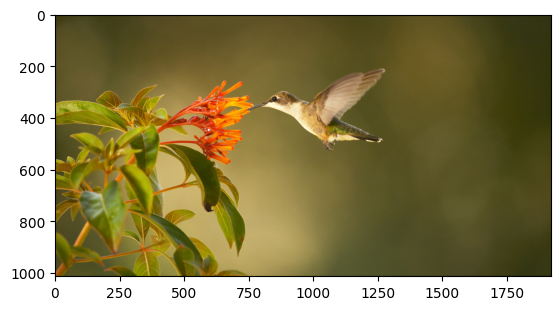

In [9]:
image_urls = [
    'https://www.pbs.org/wnet/nature/files/2019/07/Super-Hummingbirds-2.jpg',
    #'https://lumiere-a.akamaihd.net/v1/images/p_avengersendgame_19751_e14a0104.jpeg?region=0,0,540,810',
]

image_documents = load_image_urls(image_urls)

# Multi modal LLM
openai_vision_llm = OpenAIMultiModal(
    model='gpt-4-vision-preview'
)

img_response = requests.get(image_urls[0])
print(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

response = openai_vision_llm.complete(
    prompt='Describe the images as an alternative text',
    image_documents=image_documents,
)
print(response)